# Overlapping lines

In contrast to RADEX, `pythonradex` is able to treat line overlap. By overlapping lines, we mean emission lines that overlap in frequency space. Obviously, whether two lines overlap will depend on the adopted line width. If lines overlap, photons emitted by one line can be absorbed by another line, thus affecting the excitation conditions of the overlapping transitions.

Note that treating line overlap adds a lot of computational cost. This is because averages over the line profiles need to be calculated, while in the standard (non-overlap) algorithm, everything is just evaluated at the rest frequency.

As an example, let us compare the results of the radiative transfer with and without treatment of overlapping lines by considering the hyperfine structure of HCN.

## Example: the importance of treating line overlap effects for the case of HCN

In [1]:
from pythonradex import radiative_transfer
from scipy import constants
import matplotlib.pyplot as plt
import numpy as np

In [2]:
datafilepath = "./hcn@hfs.dat"  # file downloaded from LAMDA database
geometry = "static slab"
line_profile_type = "Gaussian"
width_v = 2.5 * constants.kilo
source_kwargs = {
    "datafilepath": datafilepath,
    "geometry": geometry,
    "line_profile_type": line_profile_type,
    "width_v": width_v,
    "warn_negative_tau": False,
}
# we don't consider an external background or dust in this example:
reference_source_parameters = {
    "N": 5e14 / constants.centi**2,
    "Tkin": 25,
    "collider_densities": {"H2": 1e5 / constants.centi**3},
    "ext_background": 0,
    "T_dust": 0,
    "tau_dust": 0,
}
# make two sources, one treating overlap, one ignoring overlap, and
# put them into a dictionary:
sources = {
    ID: radiative_transfer.Source(**source_kwargs, treat_line_overlap=treat)
    for ID, treat in zip(("treat overlap", "ignore overlap"), (True, False))
}

/home/gianni/science/projects/code/pythonradex_joss/pythonradex/src/pythonradex/radiative_transfer.py:138: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn(


For the chosen line width, the transitions with indices 3, 4, 5, 6, 7 and 8 are overlapping (among others). We can verify by looking at the `overlapping_lines` attribute, which is a list of lists: for each transition, it gives the list of overlapping transitions.

In [3]:
# doesn't matter which source I take here
sources["treat overlap"].emitting_molecule.overlapping_lines

[[1],
 [0, 2],
 [1],
 [4, 5, 6, 7, 8],
 [3, 5, 6, 7, 8],
 [3, 4, 6, 7, 8],
 [3, 4, 5, 7, 8],
 [3, 4, 5, 6, 8],
 [3, 4, 5, 6, 7],
 [10, 11, 12, 13, 14],
 [9, 11, 12, 13, 14],
 [9, 10, 12, 13, 14],
 [9, 10, 11, 13, 14],
 [9, 10, 11, 12, 14],
 [9, 10, 11, 12, 13],
 [16, 17, 18, 19, 20],
 [15, 17, 18, 19, 20],
 [15, 16, 18, 19, 20],
 [15, 16, 17, 19, 20],
 [15, 16, 17, 18, 20],
 [15, 16, 17, 18, 19],
 [22, 23, 24, 25, 26],
 [21, 23, 24, 25, 26],
 [21, 22, 24, 25, 26],
 [21, 22, 23, 25, 26],
 [21, 22, 23, 24, 26],
 [21, 22, 23, 24, 25],
 [28, 29, 30, 31, 32],
 [27, 29, 30, 31, 32],
 [27, 28, 30, 31, 32],
 [27, 28, 29, 31, 32],
 [27, 28, 29, 30, 32],
 [27, 28, 29, 30, 31],
 [34, 35, 36, 37, 38],
 [33, 35, 36, 37, 38],
 [33, 34, 36, 37, 38],
 [33, 34, 35, 37, 38],
 [33, 34, 35, 36, 38],
 [33, 34, 35, 36, 37],
 [40, 41, 42, 43, 44],
 [39, 41, 42, 43, 44],
 [39, 40, 42, 43, 44],
 [39, 40, 41, 43, 44],
 [39, 40, 41, 42, 44],
 [39, 40, 41, 42, 43]]

In the LAMDA file, the six transitions we consider here look as follows:

| Trans | Up | Low | Einstein [s-1] | Freq [GHz] | E_u [K] |
| --- | --- | --- | --- |--- | --- |
|  4  |  5 |  3 | 5.778E-05 | 177.25967930 | 12.76 |       
|  5  |  7 |  4 | 1.284E-04 | 177.25992460 | 12.76 |        
|  6  |  5 |  2 | 1.733E-04 | 177.26111120 | 12.76 |        
|  7  |  6 |  3 | 2.311E-04 | 177.26122200 | 12.76 |        
|  8  |  7 |  3 | 6.420E-06 | 177.26201280 | 12.76 |        
|  9  |  7 |  2 | 9.630E-05 | 177.26344470 | 12.76 | 

They are very close in frequency indeed. Note that `pythonradex` starts numbering transitions starting from 0, so these six transitions have indeed indices 3, 4, 5, 6, 7 and 8.

In [4]:
line_indices = [3, 4, 5, 6, 7, 8]

Let's solve the sources' radiative transfer:

In [5]:
for ID, source in sources.items():
    print(ID)
    source.update_parameters(**reference_source_parameters)
    source.solve_radiative_transfer()
    for i in line_indices:
        print(f"line {i}:")
        print(
            f"tau_nu0 = {source.tau_nu0_individual_transitions[i]:.2g}, "
            + f"Tex = {source.Tex[i]:.3g} K"
        )
    print("\n")

treat overlap
line 3:
tau_nu0 = 3, Tex = 9.21 K
line 4:
tau_nu0 = 3.1, Tex = 9.37 K
line 5:
tau_nu0 = 8.4, Tex = 9.68 K
line 6:
tau_nu0 = 16, Tex = 9.78 K
line 7:
tau_nu0 = 0.23, Tex = 7.37 K
line 8:
tau_nu0 = 3.2, Tex = 7.66 K


ignore overlap
line 3:
tau_nu0 = 3.7, Tex = 7.21 K
line 4:
tau_nu0 = 4.4, Tex = 5.99 K
line 5:
tau_nu0 = 9.4, Tex = 7.94 K
line 6:
tau_nu0 = 15, Tex = 11.9 K
line 7:
tau_nu0 = 0.28, Tex = 5.23 K
line 8:
tau_nu0 = 3.7, Tex = 5.61 K




We can see that there are significant differences in the excitation temperatures depending on whether line overlap effects are treated or not. With overlap treatment, the excitation temperatures become more similar to each other.

Now define the parameters for an output spectrum

In [6]:
# rest frequencies of the transitions:
nu0s = [sources["treat overlap"].emitting_molecule.nu0[i] for i in line_indices]
nu0s = sorted(nu0s)
# arbitrarily choose one of the rest frequencies to define the velocity grid:
ref_nu0 = nu0s[2]
v = np.linspace(-5 * width_v, 5 * width_v, 150)


def get_nu(v):
    return ref_nu0 * (1 - v / constants.c)


nu = get_nu(v=v)

Compare the spectrum with and without overlap treatment:

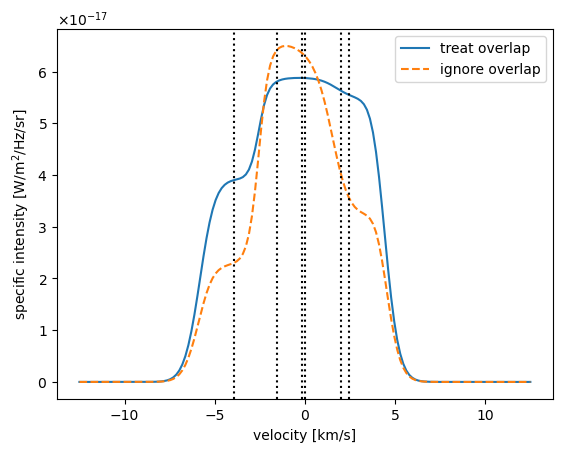

In [7]:
def compare_sources(sources, nu):
    linestyles = {"treat overlap": "solid", "ignore overlap": "dashed"}
    fig, ax = plt.subplots()
    for ID, source in sources.items():
        spectrum = source.spectrum(output_type="specific intensity", nu=nu)
        ax.plot(v / constants.kilo, spectrum, label=ID, linestyle=linestyles[ID])
    ax.legend(loc="best")
    for nu0 in nu0s:
        # mark the position of each transition with a vertical line
        ax.axvline(
            (1 - nu0 / ref_nu0) * constants.c / constants.kilo,
            color="black",
            linestyle="dotted",
        )
    ax.set_xlabel("velocity [km/s]")
    ax.set_ylabel("specific intensity [W/m$^2$/Hz/sr]")
    ax.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))


compare_sources(sources=sources, nu=nu)

## Sanity checks

### LTE

In LTE, the excitation temperature of all transitions equals the kinetic temperature. So whether line overlap is taken into account or not should not matter. Let's check it:

treat overlap
line 3:
tau_nu0 = 0.71, Tex = 24.8 K
line 4:
tau_nu0 = 0.95, Tex = 24.6 K
line 5:
tau_nu0 = 2.1, Tex = 24.8 K
line 6:
tau_nu0 = 4, Tex = 24.9 K
line 7:
tau_nu0 = 0.048, Tex = 24.6 K
line 8:
tau_nu0 = 0.72, Tex = 24.6 K


ignore overlap
line 3:
tau_nu0 = 0.72, Tex = 24.7 K
line 4:
tau_nu0 = 0.96, Tex = 24.5 K
line 5:
tau_nu0 = 2.1, Tex = 24.8 K
line 6:
tau_nu0 = 4, Tex = 25 K
line 7:
tau_nu0 = 0.048, Tex = 24.4 K
line 8:
tau_nu0 = 0.72, Tex = 24.5 K




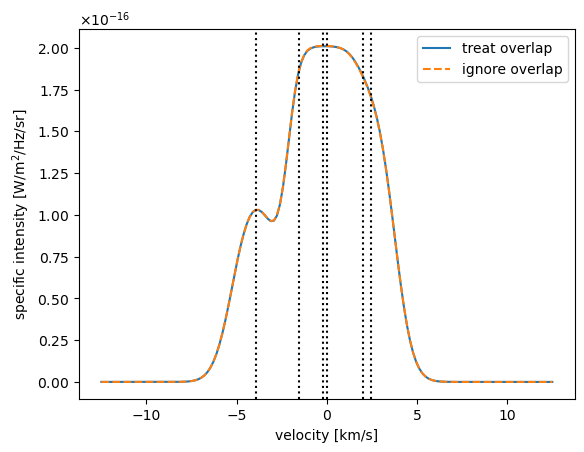

In [8]:
# high collider density to force LTE:
LTE_collider_densities = {"H2": 1e8 / constants.centi**3}
for ID, source in sources.items():
    source.update_parameters(collider_densities=LTE_collider_densities)
    source.solve_radiative_transfer()
    print(ID)
    for i in line_indices:
        print(f"line {i}:")
        print(
            f"tau_nu0 = {source.tau_nu0_individual_transitions[i]:.2g},"
            f" Tex = {source.Tex[i]:.3g} K"
        )
    print("\n")
compare_sources(sources=sources, nu=nu)

### Optically thin radiation

If the gas is optically thin, all photons escape the source without interaction. Thus, treating line overlap is not necessary. Let's check.

treat overlap
line 3:
tau_nu0 = 0.00075, Tex = 3.08 K
line 4:
tau_nu0 = 0.00099, Tex = 3.09 K
line 5:
tau_nu0 = 0.0022, Tex = 3.09 K
line 6:
tau_nu0 = 0.0042, Tex = 3.09 K
line 7:
tau_nu0 = 5e-05, Tex = 3.07 K
line 8:
tau_nu0 = 0.00075, Tex = 3.08 K


ignore overlap
line 3:
tau_nu0 = 0.00076, Tex = 3.07 K
line 4:
tau_nu0 = 0.00099, Tex = 3.08 K
line 5:
tau_nu0 = 0.0022, Tex = 3.08 K
line 6:
tau_nu0 = 0.0042, Tex = 3.08 K
line 7:
tau_nu0 = 5e-05, Tex = 3.07 K
line 8:
tau_nu0 = 0.00075, Tex = 3.07 K




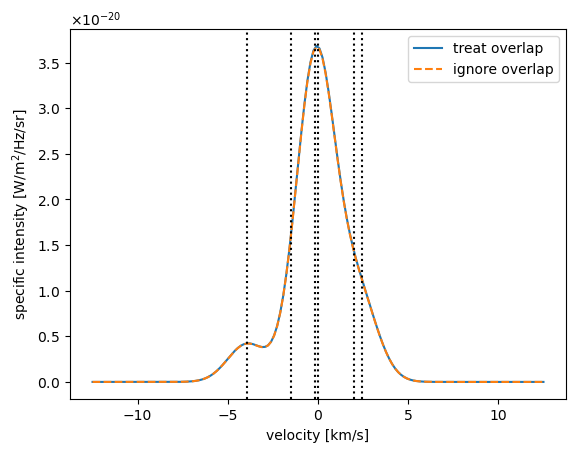

In [9]:
N_thin = 1e11 / constants.centi**2
for ID, source in sources.items():
    # need to put collider densities back to the original value
    source.update_parameters(
        collider_densities=reference_source_parameters["collider_densities"], N=N_thin
    )
    source.solve_radiative_transfer()
    print(ID)
    for i in line_indices:
        print(f"line {i}:")
        print(
            f"tau_nu0 = {source.tau_nu0_individual_transitions[i]:.2g},"
            + f" Tex = {source.Tex[i]:.3g} K"
        )
    print("\n")
compare_sources(sources=sources, nu=nu)

## Broad lines

If the line width is very broad, we observe that the excitation temperatures become very similar. This is expected if radiative processes dominate, since now all transitions see the same radiation field.

/home/gianni/science/projects/code/pythonradex_joss/pythonradex/src/pythonradex/radiative_transfer.py:138: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn(


treat overlap
line 3:
tau_nu0 = 2.5, Tex = 11.1 K
line 4:
tau_nu0 = 3.3, Tex = 11.2 K
line 5:
tau_nu0 = 7.4, Tex = 11.2 K
line 6:
tau_nu0 = 14, Tex = 11.2 K
line 7:
tau_nu0 = 0.16, Tex = 11.1 K
line 8:
tau_nu0 = 2.5, Tex = 11.1 K


ignore overlap
line 3:
tau_nu0 = 3.7, Tex = 7.21 K
line 4:
tau_nu0 = 4.4, Tex = 5.99 K
line 5:
tau_nu0 = 9.4, Tex = 7.94 K
line 6:
tau_nu0 = 15, Tex = 11.9 K
line 7:
tau_nu0 = 0.28, Tex = 5.23 K
line 8:
tau_nu0 = 3.7, Tex = 5.61 K




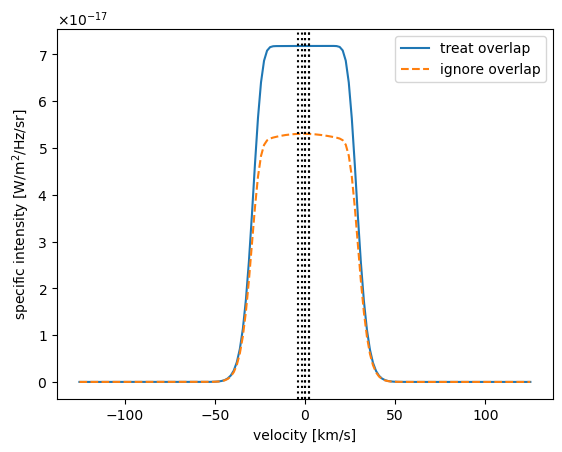

In [10]:
# need to define new sources with broader line widths
broad_line_kwargs = source_kwargs.copy()
broad_line_kwargs["width_v"] = 10 * width_v
broad_sources = {
    ID: radiative_transfer.Source(**broad_line_kwargs, treat_line_overlap=treat)
    for ID, treat in zip(("treat overlap", "ignore overlap"), (True, False))
}
broad_line_parameters = reference_source_parameters.copy()
broad_line_parameters[
    "N"
] *= 10  # to have the same optical depth as in the reference example
for ID, source in broad_sources.items():
    source.update_parameters(**broad_line_parameters)
    source.solve_radiative_transfer()
    print(ID)
    for i in line_indices:
        print(f"line {i}:")
        print(
            f"tau_nu0 = {source.tau_nu0_individual_transitions[i]:.2g}, "
            + f"Tex = {source.Tex[i]:.3g} K"
        )
    print("\n")
v_broad = v = np.linspace(
    -5 * broad_line_kwargs["width_v"], 5 * broad_line_kwargs["width_v"], 150
)
compare_sources(sources=broad_sources, nu=get_nu(v_broad))